In [1]:
import gdax
public_client = gdax.PublicClient()

In [113]:
import pandas as pd
#https://docs.gdax.com/#get-trades
def rolling_std(data, window, center, min_periods):
    return data.rolling(window, center=center, min_periods=2).std()    

def bollinger_band(data, window = 7, center = False, min_periods = 1):
    mean = data.rolling(window, center=center, min_periods=min_periods).mean()
    std = rolling_std(data, window, center, min_periods)
    return mean, mean + std, mean - std

import logging

def BTC_hist(start):
    ##https://docs.pro.coinbase.com/#get-historic-rates
    data = public_client.get_product_historic_rates('BTC-USD', start=start, granularity=3600)
    df = pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['time'],unit='s')
    df['date'].dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')    
    return df

In [7]:
%matplotlib inline
import pylab as plt

import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [108]:
df = BTC_hist(datetime.now() - timedelta(days=7))

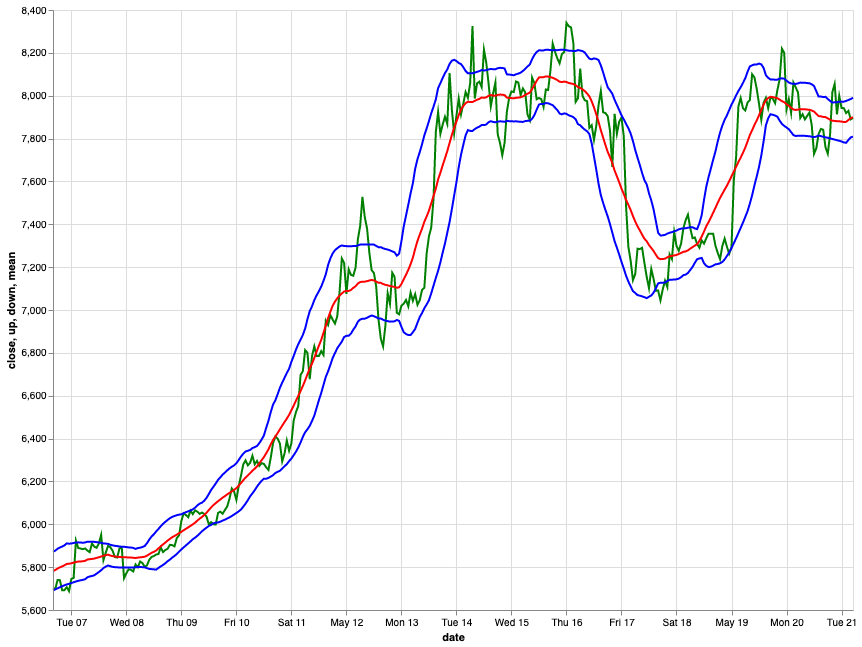

In [114]:
from functools import reduce

WIDTH, HEIGHT = 800, 600
colors = { 'close': 'green', 'up': 'blue', 'down': 'blue', 'mean': 'red'}
def alt_line_chart(df, column):
    c = alt.Chart(df, width=WIDTH, height=HEIGHT).mark_line(color=colors[column]).encode(
        alt.X('date'),
        alt.Y(column,
            scale=alt.Scale(zero=False)
        )
    )
    return c
    
def add(x, y):
    return x + y

def plot_bb(df, window = 20):
    df['close'] = df['close'].sort_index(ascending=True)
    df['mean'], df['up'], df['down'] = bollinger_band(df['close'], window = window, center = True)

    return reduce(add, map(lambda x: alt_line_chart(df, x), ['close', 'up', 'down', 'mean']))   

plot_bb(df, 30)